In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns # seaborn là thư viện được xây trên matplotlib, giúp việc visualization đỡ khổ hơn
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.neural_network import MLPClassifier
from sklearn import set_config

In [2]:
df = pd.read_csv('data.csv', sep=',')


In [3]:
df.Price = pd.to_numeric(df.Price.str.replace('.', ''), errors='coerce')

In [4]:
# Tách X và y
y_sr = df["Price"] # sr là viết tắt của series
X_df = df.drop("Price", axis=1)

In [5]:
train_X_df, val_X_df, train_y_sr, val_y_sr = train_test_split(X_df, y_sr, test_size=0.3
                                                              ,random_state=0)

In [6]:
def convert_col_dtype(col):
    if col.name == 'SSD':
        col.replace('1','1000', inplace = True)
        return pd.to_numeric(col, errors='coerce')
    if col.name == 'gen':
        col.replace('1000',np.NaN,inplace = True)
        return pd.to_numeric(col, errors='coerce')
    if col.name == 'Security':     
        return col.apply(lambda x: 'Yes' if not pd.isnull(x) else 'No')
    if col.name in ['Pin','Weight','Screen','RAM']:  
        return pd.to_numeric(col, errors='coerce')  
    if col.name == 'Price':
        col = col.str.replace('.', '')
        return pd.to_numeric(col, errors='coerce')
    return col

In [7]:
class ColAdderDropper(BaseEstimator, TransformerMixin):
    def __init__(self, num_top_titles=5):
        self.num_top_titles = num_top_titles
    def fit(self, X_df, y=None):
        self.title_counts_ = X_df.Brand.value_counts()
        titles = list(self.title_counts_.index)
        self.top_titles_ = titles[:max(1, min(self.num_top_titles, len(titles)))]
        return self
    def transform(self, X_df, y=None):
        df = X_df.copy()
        df['Brand'] =df['Brand'].apply(lambda x: x if x in col_adderdropper.top_titles_ else 'Others')
        df['CPUs'] = df['CPUgen'].str.extract(r'([A-z0-9\s]+)\,')
        df['gen'] = df['CPUgen'].str.extract(r'([0-9]+)$')
        df['namegen'] = df['CPU'].str.extract(r'([A-z0-9]+)\s\(')
        df['namegen'] = df['namegen'].str.extract(r'([A-z])')
        df['GraphicChip'] = df['GraphicChip'].str.extract(r'([A-z]+)\s')
        df['RAM'] = df['RAM'].str.extract(r'([0-9]+)GB')
        df['Screen'] = df['Screen'].str.extract(r'([0-9.]+)')
        df['SSD'] = df['Storage'].str.extract(r'([0-9]+)[A-z]')
        df['Pin'] = df['Pin'].str.extract(r'([0-9A-z]+)\scell')
        df['Weight'] = df['Weight'].str.extract(r'([0-9.]+)')
        
        unused_cols = ['SKU', 'Title', 'Warranty','Color','PartNum','MaxStoPortNum',
               'SupportM2','OutVideoPort','ConnectPort','Wireless','Keyboard',
               'Size','LED','Accessories','OptDrive','Feature','OS',
               'Storage', 'CPUgen','CPU','Pin','SeriesLaptop']

        df = df.apply(convert_col_dtype)
        df = df.drop(unused_cols,axis=1)
        return df

In [8]:
# TEST FIT METHOD
col_adderdropper = ColAdderDropper(num_top_titles=5)
col_adderdropper.fit(train_X_df)
print(col_adderdropper.title_counts_)
print()
print(col_adderdropper.top_titles_)

ASUS         40
ACER         38
Dell         26
Lenovo       20
HP           16
LG            6
MSI           3
MICROSOFT     2
Avita         2
Name: Brand, dtype: int64

['ASUS', 'ACER', 'Dell', 'Lenovo', 'HP']


In [9]:
fewer_cols_train_X_df = col_adderdropper.transform(train_X_df)

In [10]:
fewer_cols_train_X_df.head()

,Brand,GraphicChip,RAM,Screen,Weight,Security,CPUs,gen,namegen,SSD
40,ASUS,Intel,4,15.6,1.70,Yes,Core i3,10.0,G,512
13,HP,Intel,4,14.0,1.35,Yes,Core i3,10.0,G,512
118,ACER,Intel,8,14.0,1.20,Yes,Core i5,10.0,G,512
83,Others,NVIDIA,8,14.0,1.30,No,Core i5,11.0,G,512
24,HP,Intel,4,15.6,1.70,No,Core i3,10.0,G,256


In [11]:
nume_cols = ['RAM','gen','SSD']
unorder_cate_cols = ['GraphicChip', 'Brand','Security','CPUs','namegen']
order_cate_cols = ['Screen','Weight']
# YOUR CODE HERE
mean_numcols = SimpleImputer(missing_values = np.nan, strategy = 'mean')
mode_ordercols = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
mode_unordercols = make_pipeline(mode_ordercols, OneHotEncoder(handle_unknown='ignore'))

col_transform = ColumnTransformer([('nume_cols', mean_numcols, nume_cols),\
                                ('unorder_cate_cols', mode_unordercols,unorder_cate_cols),\
                                ('order_cate_cols',mode_ordercols,order_cate_cols)])

preprocess_pipeline = make_pipeline(col_adderdropper,col_transform,StandardScaler())
preprocessed_train_X = preprocess_pipeline.fit_transform(train_X_df)

In [12]:
preprocessed_train_X.shape

(153, 29)

In [13]:
preprocessed_val_X = preprocess_pipeline.transform(val_X_df)

In [14]:
preprocessed_val_X.shape

(66, 29)

In [15]:
def compute_rr(y, preds, baseline_preds):
    return (1 - (abs(y - preds) <= baseline_preds).mean()) * 100

In [16]:
# Tạo full pipeline
nume_cols = ['RAM','gen','SSD']
unorder_cate_cols = ['GraphicChip', 'Brand','Security','CPUs','namegen']
order_cate_cols = ['Screen','Weight']
# YOUR CODE HERE
neural_net_model = MLPClassifier(hidden_layer_sizes=(20), activation='tanh', solver='lbfgs', random_state=0, max_iter=2500)
full_pipeline = make_pipeline(col_adderdropper, col_transform, StandardScaler(), neural_net_model)

# Thử nghiệm với các giá trị khác nhau của các siêu tham số
# và chọn ra các giá trị tốt nhất
train_errs = []
val_errs = []
alphas = [0.1, 1, 10, 100, 1000]
num_top_titles_s = [1,3,5,7,9]
best_val_err = float('inf'); best_alpha = None; best_num_top_titles = None
for alpha in alphas:
    for num_top_titles in num_top_titles_s:
        # YOUR CODE HERE
        full_pipeline.set_params(coladderdropper__num_top_titles = num_top_titles, mlpclassifier__alpha=alpha)
        full_pipeline.fit(train_X_df, train_y_sr)
        
        
        train_errs.append(compute_rr(train_y_sr,full_pipeline.predict(train_X_df),3000000))
        val_errs.append(compute_rr(val_y_sr,full_pipeline.predict(val_X_df),3000000))
    
        
        if val_errs[-1] < best_val_err:
            best_val_err = val_errs[-1]
            best_alpha = alpha
            best_num_top_titles = num_top_titles
'Finish!'

'Finish!'

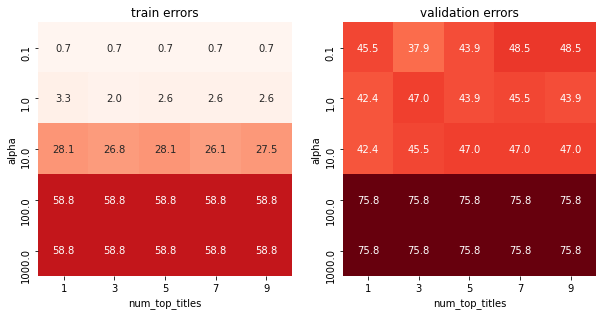

In [17]:
# Trực quan hóa kết quả
train_errs_df = pd.DataFrame(data=np.array(train_errs).reshape(len(alphas), -1),
                             index=alphas, columns=num_top_titles_s)
val_errs_df = pd.DataFrame(data=np.array(val_errs).reshape(len(alphas), -1), 
                           index=alphas, columns=num_top_titles_s)
min_err = min(min(train_errs), min(val_errs))
max_err = max(max(train_errs), max(val_errs))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('train errors'); plt.xlabel('num_top_titles'); plt.ylabel('alpha')
plt.subplot(1, 2, 2)
sns.heatmap(val_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('validation errors'); plt.xlabel('num_top_titles'); plt.ylabel('alpha');

In [18]:
full_pipeline

Pipeline(steps=[('coladderdropper', ColAdderDropper(num_top_titles=9)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('nume_cols', SimpleImputer(),
                                                  ['RAM', 'gen', 'SSD']),
                                                 ('unorder_cate_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['GraphicChip', 'Brand',
                                                   'Security', 'CPUs',
                                                   'namegen']),
                                                 ('order_cate_cols',